The purpose of this notebook is to compare multiple shower shapes using single metrics.  That could be used for e.g. evaluating the performance of an ensemble of GANs across many hyper-parameters and many epochs without investigating each one individually.  Please be warned that single numbers are not always representative of the physics quality of the NN and so care must be taken for using only these single numbers.  Correlations are not accounted for in this notebook.  In principle, the discriminator loss could also be used (and that does take into account correlations) but the focus here is on a small number of known physically-meaningful observables.

In [92]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
from feats1d import *
%matplotlib inline

Load the two samples you want to compare.  Could be {Geant4,GAN} versus {Geant4,GAN}.  For a simple illustration that works without setting up the NN, we'll show how this works with Geant4 (gamma) versus Geant4 (eplus).

In [ ]:
d_gamma = h5py.File('gamma.hdf5', 'r')
d_eplus = h5py.File('eplus.hdf5', 'r')

We will use three different metrics on the shower shapes: Separation power (commonly used in HEP) [0], Komogorov-Smirnov test, and Mann-Whitney U test.  Be warned when interpreting the final output that only the last two can be interpreted as actual probabilities (they are statisitcal tests for non-parameteric distribution comparisons).  In general, since the output is reported as a -log(x), smaller numbers are better.

[0] The BABAR Physics Book, BABAR Collaboration (P.F. Harrison and H. Quinn (editors) et al.), SLAC-R-0504 (1998).

In [59]:
def separation_power(hist1,hist2):
    #first, collate to get the bins.
    hist12 = []
    for i in range(len(hist1)):
        hist12+=[hist1[i]]
        pass
    for i in range(len(hist1)):
        hist12+=[hist2[i]]
        pass    
    mymin = min(hist12)
    mymax = max(hist12)
    nbins = 10
    delta = len(hist12) / nbins
    binvals = []
    hist12 = np.sort(hist12)
    for i in range(nbins):
        binvals+=[hist12[i*delta]]
        pass
    binvals+=[mymax]
    myhist1 = np.histogram(hist1, bins=binvals)[0]
    myhist2 = np.histogram(hist2, bins=binvals)[0]
    separation_power = 0.
    myint1 = 1.*sum(myhist1)
    myint2 = 1.*sum(myhist2)
    epsilon = 0.00001
    for i in range(len(myhist1)):
        separation_power+=0.5*pow(myhist1[i]/myint1-myhist2[i]/myint2,2) / (epsilon + myhist1[i]/myint1+myhist2[i]/myint2)
        pass
    return separation_power
    

In [13]:
#let's make all of the shower shapes

def make_shower_shapes(myinput):
    #same order as Fig. 12 here: https://arxiv.org/pdf/1705.02355.pdf
    e0 = energy('0', myinput)
    e1 = energy('1', myinput)
    e2 = energy('2', myinput)
    etot = total_energy(myinput)
    f0 = e0 / etot
    f1 = e1 / etot
    f2 = e2 / etot
    showerdepth = depth(myinput)
    
    gamma_0 = myinput['layer_0'][:]
    gamma_1 = myinput['layer_1'][:]
    gamma_2 = myinput['layer_2'][:]
    real_images_gamma = [gamma_0, gamma_1, gamma_2]
    
    ratio0 = eratio(real_images_gamma[0])
    ratio1 = eratio(real_images_gamma[1])
    ratio2 = eratio(real_images_gamma[2])
    mylateral_depth = lateral_depth(myinput)
    lateral_width0 = layer_lateral_width('0', myinput)
    lateral_width1 = layer_lateral_width('1', myinput)
    lateral_width2 = layer_lateral_width('2', myinput)
    shower_depth = mylateral_depth / etot
    real_sparsity_gamma = map(lambda x: (x > 0).mean((1, 2)), real_images_gamma)
    mysparse0 = real_sparsity_gamma[0]
    mysparse1 = real_sparsity_gamma[1]
    mysparse2 = real_sparsity_gamma[2]
    mylateral_depth2 = lateral_depth2(myinput)
    shower_depth_width_orig = shower_depth_width(mylateral_depth, mylateral_depth2, etot)
    return [e0,e1,e2,etot,f0,f1,f2,showerdepth,ratio0,ratio1,ratio2,mylateral_depth,lateral_width0,lateral_width1,lateral_width2,shower_depth,mysparse0,mysparse1,mysparse2,shower_depth_width_orig]

In [38]:
myshowershapes = make_shower_shapes(d_gamma)
myshowershapes_eplus = make_shower_shapes(d_eplus)

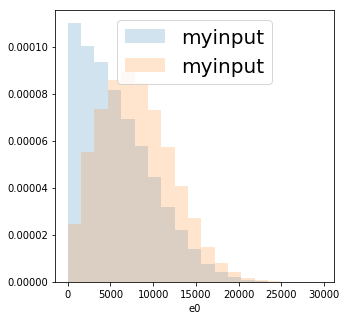

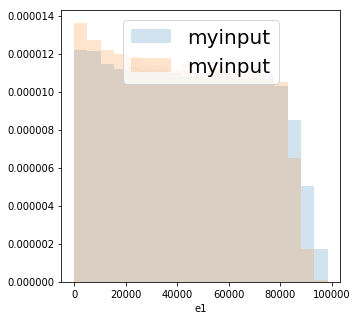

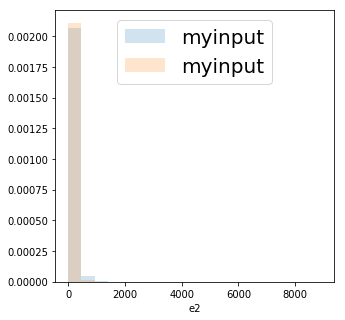

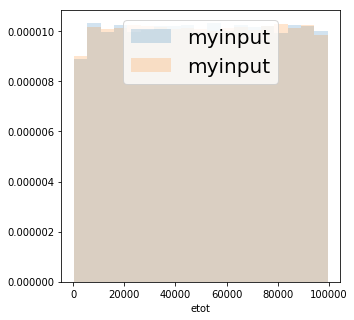

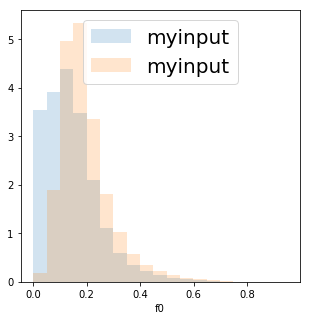

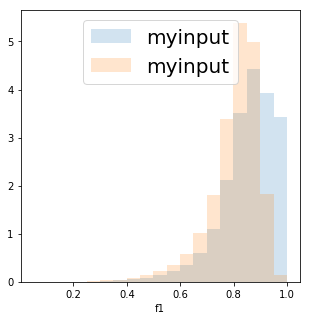

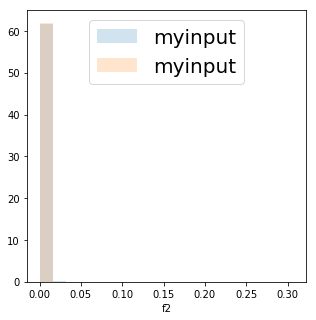

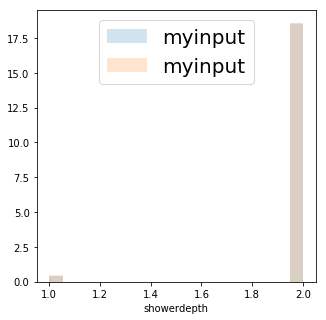

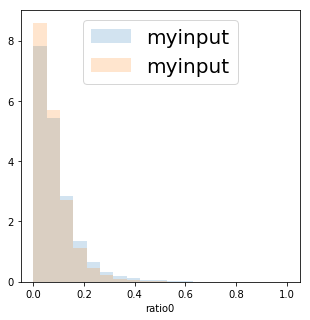

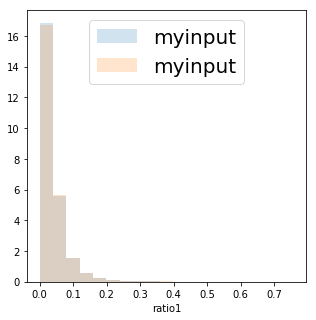

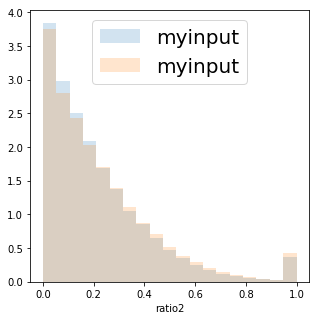

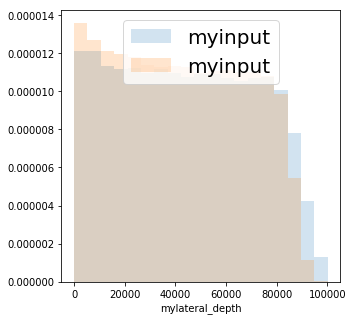

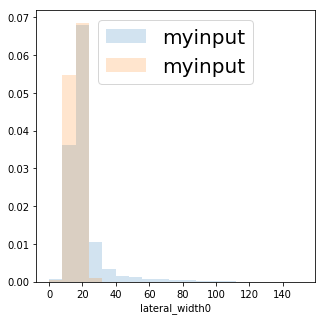

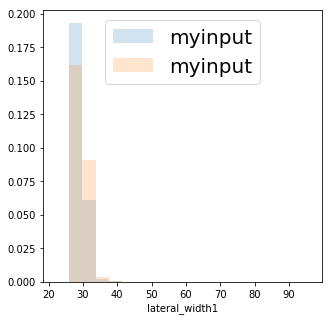

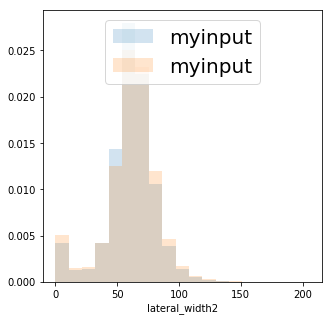

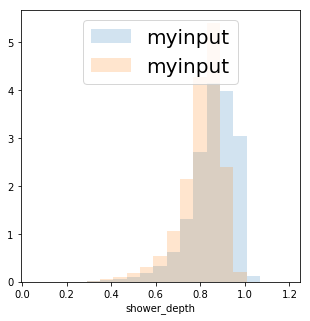

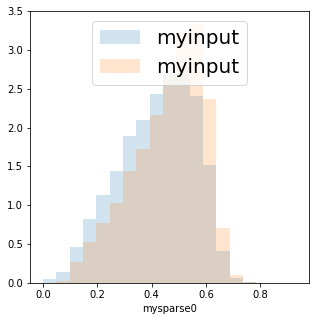

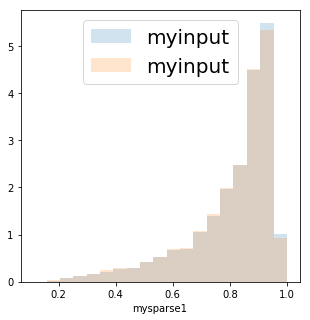

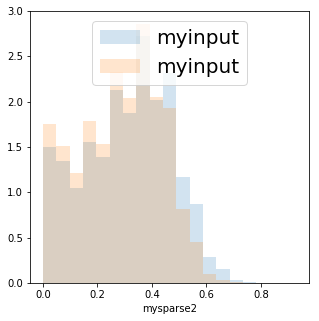

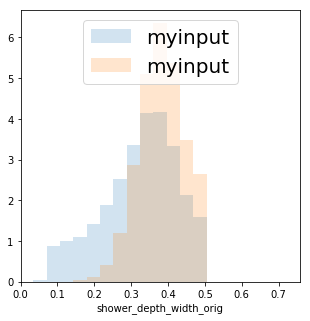

In [44]:
#let's now make sure things look like they should.
mynames = ['e0','e1','e2','etot','f0','f1','f2','showerdepth','ratio0','ratio1','ratio2','mylateral_depth','lateral_width0','lateral_width1','lateral_width2','shower_depth','mysparse0','mysparse1','mysparse2','shower_depth_width_orig']
for i in range(len(myshowershapes)):
    bins = np.linspace(min(myshowershapes[i]), max(myshowershapes[i]), 20)
    plt.figure(figsize=(5, 5))
    _ = plt.hist(myshowershapes[i], bins=bins, histtype='stepfilled', linewidth=2,
                 alpha=0.2, normed='True',
                 label='input 1')
    _ = plt.hist(myshowershapes_eplus[i], bins=bins, histtype='stepfilled', linewidth=2,
                 alpha=0.2, normed='True',
                 label='input 2')
    plt.legend(loc='upper center', ncol=1, fontsize=20)
    plt.xlabel(mynames[i])

In [56]:
separation_power(myshowershapes[0],myshowershapes_eplus[0])

0.08359126800000001

In [46]:
ks_2samp(myshowershapes[0],myshowershapes_eplus[0]).pvalue

0.0

In [72]:
mannwhitneyu(myshowershapes[0],myshowershapes_eplus[0]).pvalue

0.0

In [81]:
def separation_many(shower1,shower2):
    myinf = 1000. #biggest number I can think of right now.
    myoutput_separation = 0.
    myoutput_KS = 0.
    myoutput_MW = 0.
    for i in range(len(shower1)):
        mysep = separation_power(shower1[i],shower2[i])
        myKS = ks_2samp(shower1[i],shower2[i]).pvalue
        myMW = mannwhitneyu(shower1[i],shower2[i]).pvalue
        if (mysep > 0):
            myoutput_separation += -np.log(mysep)
        else:
            myoutput_separation += myinf
        if (myKS > 0):
            myoutput_KS += -np.log(myKS)
        else:
            myoutput_KS += myinf
        if (myMW > 0):
            myoutput_MW += -np.log(myMW)
        else:
            myoutput_MW += myinf
        pass
    return myoutput_separation,myoutput_KS,myoutput_MW

In [82]:
separation_many(myshowershapes,myshowershapes_eplus)

(97.705764622245141, 11333.085935796656, 11620.002271570353)